## Stocks Significance Testing & p-Hacking

In [68]:
#standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import pandas_datareader.data as web
import seaborn as sns

In [69]:
#resize charts to fit screen if using Jupyter Notebook
plt.rcParams['figure.figsize']=[15,5]

In [70]:
#Daily S&P500 data from 1986==>
url = "https://raw.githubusercontent.com/Patrick-David/Stocks_Significance_PHacking/master/spx.csv"
df = pd.read_csv(url,index_col='date', parse_dates=True)

In [71]:
#view raw S&P500 data
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [72]:
#To model returns we will use daily % change
daily_ret = df['close'].pct_change()
#drop the 1st value - nan
daily_ret.dropna(inplace=True)
#daily %change
daily_ret.head()

date
1986-01-03    0.006155
1986-01-06   -0.001091
1986-01-07    0.014954
1986-01-08   -0.027268
1986-01-09   -0.008944
Name: close, dtype: float64

date
1986-01-31    0.033317
1986-02-28    0.023585
1986-03-31    0.027961
1986-04-30    0.037426
1986-05-31    0.027412
Freq: M, Name: close, dtype: float64


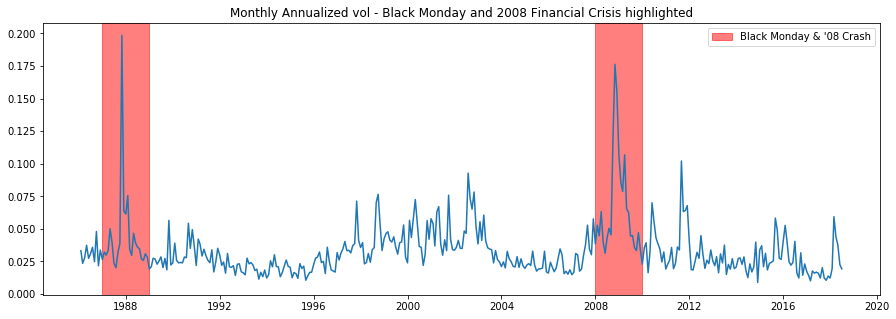

In [73]:
#use pandas to resample returns per month and take Standard Dev as measure of Volatility
#then annualize by multiplying by sqrt of number of periods (12)
mnthly_annu = daily_ret.resample('M').std()* np.sqrt(12)

print(mnthly_annu.head())
#we can see major market events show up in the volatility
plt.plot(mnthly_annu)
plt.axvspan('1987','1989',color='r',alpha=.5)
plt.axvspan('2008','2010',color='r',alpha=.5)
plt.title('Monthly Annualized vol - Black Monday and 2008 Financial Crisis highlighted')
labs = mpatches.Patch(color='red',alpha=.5, label="Black Monday & '08 Crash")
plt.legend(handles=[labs])


In [74]:
#for each year rank each month based on volatility lowest=1 Highest=12
ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()



In [75]:
#average the ranks over all years for each month
final = ranked.groupby(ranked.index.month).mean()

final.describe()

count    12.000000
mean      6.450521
std       0.627458
min       5.218750
25%       6.031013
50%       6.491004
75%       6.704545
max       7.531250
Name: close, dtype: float64

In [76]:
#the final average results over 32 years 
final

date
1     6.818182
2     6.666667
3     6.575758
4     7.303030
5     6.606061
6     6.030303
7     6.031250
8     5.875000
9     6.406250
10    7.531250
11    6.343750
12    5.218750
Name: close, dtype: float64

In [77]:
max(final)

7.53125

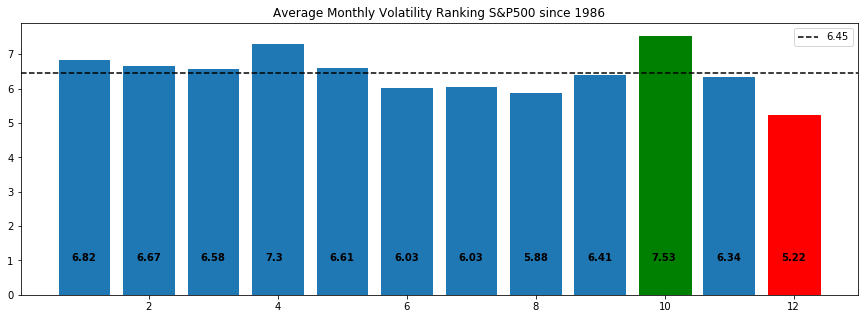

In [78]:
#plot results for ranked s&p 500 volatility
#clearly October has the highest AMVR
#and December has the lowest
#mean of 6.45 is plotted

b_plot = plt.bar(x=final.index,height=final)
b_plot[9].set_color('g')
b_plot[11].set_color('r')
for i,v in enumerate(round(final,2)):
    plt.text(i+.8,1,str(v), color='black', fontweight='bold')
plt.axhline(final.mean(),ls='--',color='k',label=round(final.mean(),2))
plt.title('Average Monthly Volatility Ranking S&P500 since 1986')

plt.legend()
plt.show()




In [79]:
#take abs value move from the mean
#we see Dec and Oct are the biggest abs moves

fin = abs(final - final.mean())
print(fin.sort_values())
Oct_value = fin[10]
Dec_value = fin[12]
print('Extreme Dec value:', Dec_value)
print('Extreme Oct value:', Oct_value)


date
9     0.044271
11    0.106771
3     0.125237
5     0.155540
2     0.216146
1     0.367661
7     0.419271
6     0.420218
8     0.575521
4     0.852509
10    1.080729
12    1.231771
Name: close, dtype: float64
Extreme Dec value: 1.231770833333333
Extreme Oct value: 1.080729166666667


##  Simulation with sampling from true returns data

In [80]:
#as our Null is that no seasonality exists or alternatively that the month does not matter in terms of AMVR,
#we can shuffle 'date' labels
#for simplicity, we will shuffle the 'daily' return data, which has the same effect as shuffling 'month' labels

#generate null data 

new_df_sim = pd.DataFrame()
highest_only = []

count=0
n=1000
for i in range(n):
    #sample same size as dataset, drop timestamp
    daily_ret_shuffle = daily_ret.sample(8191).reset_index(drop=True)
    #add new timestamp to shuffled data
    daily_ret_shuffle.index = (pd.bdate_range(start='1986-1-3',periods=8191))
    
    #then follow same data wrangling as before...
    mnthly_annu = daily_ret_shuffle.resample('M').std()* np.sqrt(12)
    
    ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()
    sim_final = ranked.groupby(ranked.index.month).mean()
    #add each of 1000 sims into df
    new_df_sim = pd.concat([new_df_sim,sim_final],axis=1)
    
    #also record just highest AMVR for each year (we will use this later for p-hacking explanation)
    maxi_month = max(sim_final)
    highest_only.append(maxi_month)
    

    
#calculate absolute deviation in AMVR from the mean
all_months = new_df_sim.values.flatten()
mu_all_months = all_months.mean()
abs_all_months = abs(all_months-mu_all_months)    

#calculate absolute deviation in highest only AMVR from the mean
mu_highest = np.mean(highest_only)
abs_highest = [abs(x - mu_all_months) for x in highest_only]



In [81]:
#count number of months in sim data where ave-vol-rank is >= Dec
#Note: we are using Dec not Oct, as Dec has highest absolute deviation from the mean
count=0
for i in abs_all_months:
    if i> Dec_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )

p-value: 0.042083333333333334


In [82]:
#same again but just considering highest AMVR for each of 100 trials
count=0
for i in abs_highest:
    if i> Dec_value:
        count+=1
ans = count/len(abs_highest)        
print('p-value:', ans )

p-value: 0.225


In [83]:
abs_all_months_95 = np.quantile(abs_all_months,.95)
abs_highest_95 = np.quantile(abs_highest,.95)

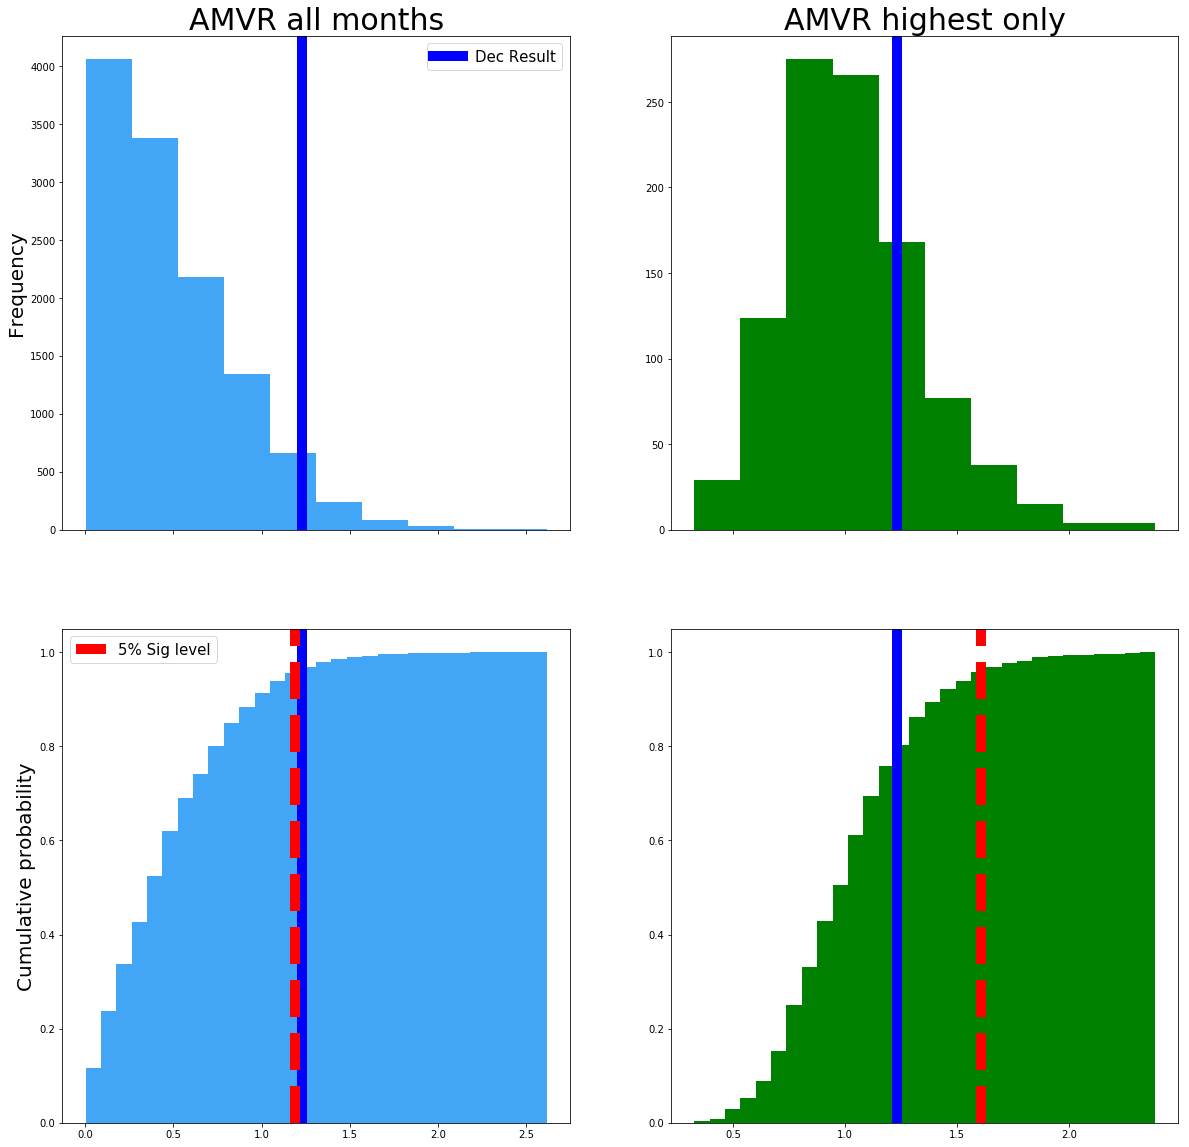

In [84]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',figsize=(20,20))

#need to normalize!

#plot 1
ax1.hist(abs_all_months,histtype='bar',color='#42a5f5')
ax1.set_title('AMVR all months',fontsize=30)
ax1.set_ylabel('Frequency',fontsize=20)
n,bins,patches = ax3.hist(abs_all_months,density=1,histtype='bar',cumulative=True,bins=30,color='#42a5f5')
ax3.set_ylabel('Cumulative probability',fontsize=20)
ax1.axvline(Dec_value,color='b',label='Dec Result',lw=10)
ax3.axvline(Dec_value,color='b',lw=10)
ax3.axvline(abs_all_months_95,color='r',ls='--',label='5% Sig level',lw=10)


#plot2
ax2.hist(abs_highest,histtype='bar',color='g')
ax2.set_title('AMVR highest only',fontsize=30)
ax2.axvline(Dec_value,color='b',lw=10)
n,bins,patches = ax4.hist(abs_highest,density=1,histtype='bar',cumulative=True,bins=30,color='g')
ax4.axvline(Dec_value,color='b',lw=10)
ax4.axvline(abs_highest_95,color='r',ls='--',lw=10)

ax1.legend(fontsize=15)
ax3.legend(fontsize=15)
